# Summarize CMIP6 data within a polygon (YK Delta)

This notebook will demonstrate downloading and summarizing some of SNAP's CMIP6 holdings for an arbitrary polygon. We will demonstrate spatial and seasonal aggregation of monthly average temperature and total precipitation projections.

(Internal SNAP note - this notebook was developed to support the work of reseachers in IARC and should be preserved accordingly.)

In [1]:
import requests
import geopandas as gpd
import urllib.parse
import io
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cftime
import rioxarray
import rasterio.features

## Polygon: Yukon-Kuskokwim Delta

The goal is to spatially average the monthly precipitation and air temperature variables within a polygon representing the Yukon-Kuskokwim delta.

Read in the shapefile to be used for the spatial aggregation and inspect:

In [2]:
yk_gdf = gpd.read_file("YK_domain_YDNWR_plus_ecoregion_akalb83.shp")
yk_gdf.head()

,FID_admndb,NAME,FID_Ecoreg,AREA,PERIMETER,ECOREGFNLA,ECOREGFN_1,DISSOLVE1,COMMONER,LEVEL_1,LEVEL_22,Physiog,Shape_Leng,Shape_Area,geometry
0,-1,None,234,1.408386e+11,2402817.25,0.0,0.0,0,Yukon-Kuskokwim Delta,Polar,Subarctic Taiga,None,151712.726394,4.556084e+08,"POLYGON ((-438135.748 1078513.252, -437883.377..."
1,-1,None,234,1.408386e+11,2402817.25,0.0,0.0,0,Yukon-Kuskokwim Delta,Polar,Subarctic Taiga,None,151712.726394,4.556084e+08,"POLYGON ((-563923.375 1131206.752, -564093.875..."
2,-1,None,234,1.408386e+11,2402817.25,0.0,0.0,0,Yukon-Kuskokwim Delta,Polar,Subarctic Taiga,None,151712.726394,4.556084e+08,"POLYGON ((-556789.372 1133014.252, -556764.624..."
3,-1,None,234,1.408386e+11,2402817.25,0.0,0.0,0,Yukon-Kuskokwim Delta,Polar,Subarctic Taiga,None,151712.726394,4.556084e+08,"POLYGON ((-498630.375 1134280.497, -498595.313..."
4,-1,None,234,1.408386e+11,2402817.25,0.0,0.0,0,Yukon-Kuskokwim Delta,Polar,Subarctic Taiga,None,151712.726394,4.556084e+08,"POLYGON ((-565684.623 1131114.003, -565652.625..."


<Axes: >

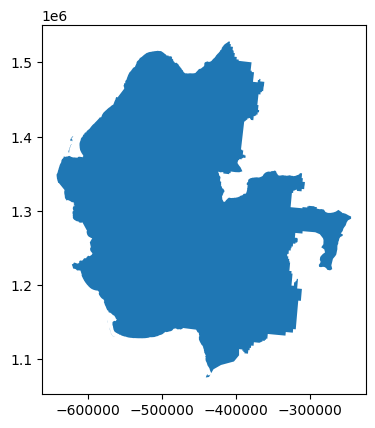

In [3]:
yk_gdf.plot()

There are multiple polygons in this shapefile - all of them besides the main polygon are small features like islands. We really just need the main polygon covering the bulk of the YK delta for summarization over the coarse ~100km grid of the CMIP6 data, so we'll have to do some prep work. 

We can first simplify the polygon to make it easier to work with, then use the `geopandas.GeoDataFrame` to do the conversion to WGS84, because the CMIP6 data is in that same CRS. 

<Axes: >

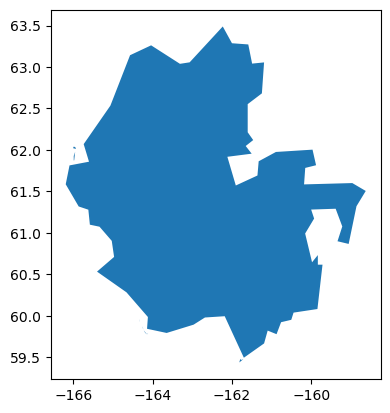

In [4]:
yk_gdf_4326 = yk_gdf.simplify(5000).to_crs(4326)
yk_gdf_4326.plot()

Then we can drop the smaller polygons keeping the main one:

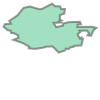

In [5]:
# simplifying the polygon first, because we don't need the fine detail for the coarse grid
yk_poly_4326 = max(yk_gdf_4326.geometry, key=lambda a: a.area)
yk_poly_4326

### WCS Download

We will now download the data with a WCS query. See the `snap_rasdaman_access.ipynb` for more info on accessing data on SNAP's raster database, Rasdaman.

Get the lat / lon bounds to query the subset of data we need:

In [6]:
west, south, east, north = yk_poly_4326.bounds
# hard-coding the time series 1980-2100 and the lat/lon subset
wcs_base_str = "GetCoverage&COVERAGEID={cov_id}&SUBSET=ansi(%221980-01-15T12:00:00.000Z%22,%222100-12-15T12:00:00.000Z%22)&SUBSET=lat({sb},{nb})&SUBSET=lon({wb},{eb})&FORMAT=application/netcdf"
# base URL for the WCS service
base_url = "https://zeus.snap.uaf.edu/rasdaman/ows?SERVICE=WCS&VERSION=2.0.1&REQUEST={request_str}"
# pad by 0.25 degrees to ensure we get all pixels that could be clipped
bounds_di = dict(sb=south - 0.25, nb=north + 0.25, wb=west - 0.25, eb=east + 0.25)
# wcs_str = wcs_base_str.format(cov_id="cmip6_monthly_precipitation", **bounds_di)
base_wcs_url = base_url.format(request_str=wcs_base_str)

# should be ~25 MB
r = requests.get(base_wcs_url.format(cov_id="cmip6_monthly_precipitation", **bounds_di))
pr_ds = xr.open_dataset(io.BytesIO(r.content))

Unfortunately, the time coordinates are incorrect. If we decode manually:

In [7]:
pr_ds = xr.open_dataset(io.BytesIO(r.content), decode_times=False)
pr_ds.ansi

<xarray.DataArray 'ansi' (ansi: 1452)>
array([138441.5, 138472.5, 138501.5, ..., 182544.5, 182575.5, 182605.5])
Coordinates:
  * ansi     (ansi) float64 1.384e+05 1.385e+05 ... 1.826e+05 1.826e+05
Attributes:
    axis:           T
    bounds:         time_bnds
    calendar:       noleap
    standard_name:  time
    title:          time
    type:           double
    units:          days since 1950-01-01

Given the units value of days since 1950-01-01, we would expect the encoded time series to be something like ~10950, 10920, ...

For example, decoding the values returns:

In [8]:
cftime.num2date(pr_ds.ansi.values, units="Days since 1950-01-01", calendar="noleap")

array([cftime.DatetimeNoLeap(2329, 4, 17, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2329, 5, 18, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2329, 6, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2450, 2, 14, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2450, 3, 17, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2450, 4, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)

The floating point values clearly do not represent days since 1950... However, the time values do seem to increment by ~30 days. So we will create a new object containing the correct 1980-2100 timeseries based on a 0-valued first element:

In [9]:
ts = cftime.num2date(
    # first day since 1980-01-01 should be 0
    (pr_ds.ansi.values - pr_ds.ansi.values[0]).astype(int),
    units="Days since 1980-01-01",
    calendar="noleap",
)
pr_ds = pr_ds.rename(ansi="time").assign_coords(time=ts)
pr_ds.time

<xarray.DataArray 'time' (time: 1452)>
array([cftime.DatetimeNoLeap(1980, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1980, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1980, 3, 2, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 10, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1980-01-01 00:00:00 ... 2100-12-31 00:00:00

Now we can decode the month and scenario coordinates as well.

Normally, we would be able to get these encodings from the coverage itself via a DescribeCoverage request. However, these coverages do not currently have that information at this time. So we will use a manual lookup dict for converting between the integer-valued model/scenario axes and the models/scenarios these values represent. 

In [10]:
model_lu = {
    0: "CESM2",
    1: "CNRM-CM6-1-HR",
    2: "EC-Earth3-Veg",
    3: "GFDL-ESM4",
    4: "HadGEM3-GC31-LL",
    5: "HadGEM3-GC31-MM",
    6: "KACE-1-0-G",
    7: "MIROC6",
    8: "MPI-ESM1-2-HR",
    9: "MRI-ESM2-0",
    10: "NorESM2-MM",
    11: "TaiESM1",
}

scenario_lu = {0: "historical", 1: "ssp126", 2: "ssp245", 3: "ssp370", 4: "ssp585"}
model_encoding_lu = {v: k for k, v in model_lu.items()}
scenario_encoding_lu = {v: k for k, v in scenario_lu.items()}

pr_ds = pr_ds.assign_coords(
    model=[model_lu[m] for m in pr_ds.model.values],
    scenario=[scenario_lu[s] for s in pr_ds.scenario.values],
)
pr_ds

<xarray.Dataset>
Dimensions:   (model: 12, scenario: 5, time: 1452, lon: 7, lat: 5)
Coordinates:
  * time      (time) object 1980-01-01 00:00:00 ... 2100-12-31 00:00:00
  * lat       (lat) float64 63.61 62.67 61.73 60.79 59.84
  * lon       (lon) float64 -166.2 -165.0 -163.8 -162.5 -161.2 -160.0 -158.8
  * model     (model) <U15 'CESM2' 'CNRM-CM6-1-HR' ... 'NorESM2-MM' 'TaiESM1'
  * scenario  (scenario) <U10 'historical' 'ssp126' 'ssp245' 'ssp370' 'ssp585'
Data variables:
    crs       |S1 ...
    pr        (model, scenario, time, lon, lat) float64 ...
Attributes:
    Encoding:  
    Title:     CMIP6 monthly precipitation on common grid

### Summarize within YK polygon

Now let's do the summarization within the polygon. We will do this by creating a mask for the data array so that we can nullify all pixels outside of the polygon and then just average the remaining pixels. 

We will use the `all_touched` option to be more inclusive of pixels, since we would otherwise only have 11 pixels within the polygon:

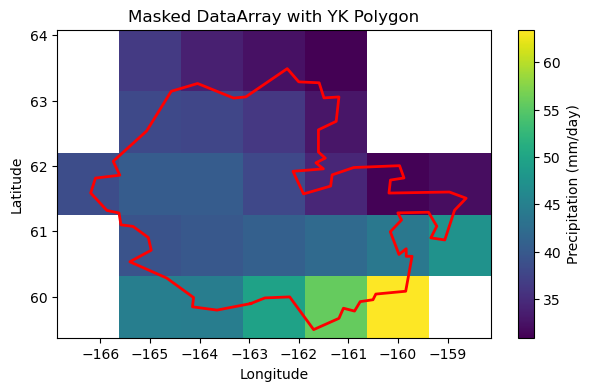

In [11]:
# using rioxarray to get the transform from the dataset
pr_ds = pr_ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
# transpose spatially for ergs
pr_ds = pr_ds.transpose("model", "scenario", "time", "lat", "lon")

mask = rasterio.features.geometry_mask(
    [yk_poly_4326],
    out_shape=pr_ds.pr.isel(time=0, model=0, scenario=0).shape,
    transform=pr_ds.rio.transform(),
    invert=True,
    all_touched=True,
)
# make dataarray to mask entire pr da
mask_da = xr.DataArray(
    mask, coords={"lat": pr_ds.lat, "lon": pr_ds.lon}, dims=["lat", "lon"]
)

fig, ax = plt.subplots(figsize=(7, 4))
pr_ds.pr.where(mask).isel(time=0, model=0, scenario=0).plot(
    ax=ax, label="Masked DataArray", cbar_kwargs={"label": "Precipitation (mm/day)"}
)

x, y = yk_poly_4326.exterior.xy
ax.plot(x, y, color="red", linewidth=2, label="Polygon")


ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Masked DataArray with YK Polygon")
plt.show()

Looks good. Now aggregate!

In [12]:
pr_df = (
    pr_ds["pr"]
    .where(mask)
    .mean(dim=["lat", "lon"])
    .to_dataset()
    .groupby("time.year")
    .apply(lambda x: x.sel(time=x.time.dt.month.isin([5, 6, 7, 8, 9])).sum(dim="time"))
    .to_dataframe()
    .reset_index()
)
pr_df

,model,scenario,year,pr
0,CESM2,historical,1980,434.847492
1,CESM2,historical,1981,256.293536
2,CESM2,historical,1982,333.280728
3,CESM2,historical,1983,257.119331
4,CESM2,historical,1984,526.636699
...,...,...,...,...
7255,TaiESM1,ssp585,2096,326.586419
7256,TaiESM1,ssp585,2097,435.943732
7257,TaiESM1,ssp585,2098,454.003014
7258,TaiESM1,ssp585,2099,344.104876


### Temperature

Do the same for temperature:

In [13]:
r = requests.get(
    base_wcs_url.format(cov_id="cmip6_monthly_air_temperature", **bounds_di)
)
tas_ds = xr.open_dataset(io.BytesIO(r.content), decode_times=False)
tas_ds = tas_ds.rename(ansi="time").assign_coords(time=ts)
tas_ds = tas_ds.assign_coords(
    model=[model_lu[m] for m in tas_ds.model.values],
    scenario=[scenario_lu[s] for s in tas_ds.scenario.values],
)
tas_ds = tas_ds.transpose("model", "scenario", "time", "lat", "lon")
tas_df = (
    tas_ds["tas"]
    .where(mask)
    .mean(dim=["lat", "lon"])
    .to_dataset()
    .groupby("time.year")
    # avg the months for temp
    .apply(lambda x: x.sel(time=x.time.dt.month.isin([5, 6, 7, 8, 9])).mean(dim="time"))
    .to_dataframe()
    .reset_index()
)
tas_df

,model,scenario,year,tas
0,CESM2,historical,1980,6.758354
1,CESM2,historical,1981,5.792361
2,CESM2,historical,1982,5.445833
3,CESM2,historical,1983,7.796097
4,CESM2,historical,1984,7.672102
...,...,...,...,...
7255,TaiESM1,ssp585,2096,15.274991
7256,TaiESM1,ssp585,2097,14.292409
7257,TaiESM1,ssp585,2098,13.514752
7258,TaiESM1,ssp585,2099,15.017642


### QC

Values look plausible. Let's do some quality control to be sure. 

Let's drop null combos (where precip is 0 or where temperature is NaN) and ensure that model / scenarios are consistent (this isn't a rule for CMIP6, but we expect it to be true for this data based on prior exploration):

In [14]:
cols = ["model", "scenario", "year"]
pr_df = pr_df.query("pr != 0").reset_index(drop=True)
tas_df = tas_df.dropna().reset_index(drop=True)
assert np.all(pr_df[cols] == tas_df[cols])

Let's double-check the spatial aggregation using a separate method. This is an opportunity to test some WCPS clipping and averaging! That is, we will let Rasdaman do the spatial averaging.

Here is the base WCPS query. WCPS stands for web coverage processing service, and it allows

>the extraction, processing, and analysis of multi-dimensional coverages

([about WCPS](https://www.ogc.org/standard/wcps/))

It is a language on its own, but this notebook will not go into any more depth on it. You simply need to know that the below request will average the supplied coverage within the supplied polygon, for each of all 12 models and all 5 scenarios (1 historical plus 4 projected emissions scenarios).

In [15]:
wcps_query = """
  for $c in ({cov_id})
    return
    encode(
        coverage timeseries
        over $t t(imageCrsDomain($c[ansi("1980-01-01T12:00:00.000Z":"2100-12-15T12:00:00.000Z")], ansi)), $m model(0:11), $s scenario(0:4)
        values avg(
        clip($c[model($m), scenario($s), ansi($t)], 'POLYGON (({wkt_latlon_str}))')
        ),
        
        "application/netcdf"
    )
)
""".strip().replace(
    "\n", ""
)  # just removing newlines because that's all we need to remove

We need the WKT string of the polygon to include in the query:

In [16]:
wkt = str(yk_poly_4326)
wkt

'POLYGON ((-162.9706326185425 59.89422667819834, -163.6500180456459 59.79432082806075, -164.1442253007357 59.84466361153758, -164.1227546646882 59.98660202475141, -164.6625642018315 60.28384889426243, -165.4062507678092 60.5336745689149, -164.9754754503139 60.71073975372692, -165.0346550377156 60.90450088826059, -165.3434878223257 61.07501777495791, -165.5868226031111 61.0993243692258, -165.6251847029739 61.28005128142058, -165.8692408729038 61.31905158575416, -166.1960997291038 61.58627777208319, -166.1003531727906 61.81377549896754, -165.6087761507595 61.85844599696321, -165.7428581233515 62.07039580630016, -165.0690805200686 62.53419503985389, -164.572960200138 63.14195568912188, -164.0414989299518 63.26108465404154, -163.3141531194293 63.03823554322067, -163.0694600093971 63.05615037850386, -162.2336836884261 63.48837247875839, -162.0017938880275 63.28625368205916, -161.5901822970316 63.27182013597678, -161.4934723108589 63.04081214887458, -161.1917855941039 63.05525913568217, -161

And we need to switch the order to lat, lon for proper syntax:

In [17]:
def flip_str(ll_str):
    lon, lat = ll_str.split(" ")
    return f"{lat} {lon}"


wkt_latlon_str = ", ".join(
    [flip_str(x) for x in wkt.split("((")[1].split("))")[0].split(", ")]
)

Set up some string templates for URL creation.

In [18]:
wcps_base_str = "ProcessCoverages&QUERY={wcps_query}"
base_wcps_url = base_url.format(request_str=wcps_base_str)

Construct the WCPS request and send it:

In [19]:
pr_wcps_query = wcps_query.format(
    cov_id="cmip6_monthly_precipitation", wkt_latlon_str=wkt_latlon_str
)
pr_wcps_query = urllib.parse.quote_plus(pr_wcps_query).replace("+", "%20")

url = base_wcps_url.format(wcps_query=pr_wcps_query)
r = requests.get(url)
r

<Response [200]>

Now open the result in a xarray dataset, since we chose netcdf as the result encoding type:

In [20]:
pr_ds_2 = xr.open_dataset(io.BytesIO(r.content))

Unfortunately, the resulting netcdf from the WCPS query has little useful information. The time axis is again floats, not even integers. Plus it has a different first element. We will need to decode again:

In [21]:
pr_ds_2.t

<xarray.DataArray 't' (t: 1452)>
array([ 360.5,  361.5,  362.5, ..., 1809.5, 1810.5, 1811.5])
Coordinates:
  * t        (t) float64 360.5 361.5 362.5 363.5 ... 1.81e+03 1.81e+03 1.812e+03

We can functionally think of these values as "months since 1950-01-01", even if that is not technically true. Doing this is a quick trick to give us a useful monthly time series, though:

In [22]:
wcps_ts = cftime.num2date(
    pr_ds_2.t.values, units="Months since 1950-01-01", calendar="360_day"
)
# rename stuff too
pr_ds_2 = pr_ds_2.assign_coords(t=ts).rename(t="time", band1="pr")
pr_ds_2

<xarray.Dataset>
Dimensions:   (time: 1452, model: 12, scenario: 5)
Coordinates:
  * model     (model) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * scenario  (scenario) float64 0.5 1.5 2.5 3.5 4.5
  * time      (time) object 1980-01-01 00:00:00 ... 2100-12-31 00:00:00
Data variables:
    pr        (time, model, scenario) float64 ...

Now we need to do some other trickery to decode the other coordinate axes.

We will simply "floor" all of the coordinates to get the integer values. For some reason, our current setup with Rasdaman returns netCDFs with +0.5 added to the integer coordinates used to represent the discrete values of irregular (discrete) axes like model and scenario.

In [23]:
pr_ds_2 = pr_ds_2.assign_coords(
    model=[model_lu[np.floor(m)] for m in pr_ds_2.model.values],
    scenario=[scenario_lu[np.floor(s)] for s in pr_ds_2.scenario.values],
    # also convert the time to a noleap calendar as it will make time-based subsetting easier
).convert_calendar("noleap", align_on="year")
pr_ds_2

<xarray.Dataset>
Dimensions:   (time: 1452, model: 12, scenario: 5)
Coordinates:
  * model     (model) <U15 'CESM2' 'CNRM-CM6-1-HR' ... 'NorESM2-MM' 'TaiESM1'
  * scenario  (scenario) <U10 'historical' 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * time      (time) object 1980-01-01 00:00:00 ... 2100-12-31 00:00:00
Data variables:
    pr        (time, model, scenario) float64 ...

There, a nice and tidy dataset. Now we can average over the summer months using groupby:

In [24]:
pr_df_2 = (
    pr_ds_2.groupby("time.year")
    .apply(lambda x: x.sel(time=x.time.dt.month.isin([5, 6, 7, 8, 9])).sum(dim="time"))
    .to_dataframe()
)
pr_df_2

pr
year model   scenario              
1980 CESM2   historical  440.738940
             ssp126        0.000000
             ssp245        0.000000
             ssp370        0.000000
             ssp585        0.000000
...                             ...
2100 TaiESM1 historical    0.000000
             ssp126      390.646457
             ssp245      477.912735
             ssp370      352.177155
             ssp585      406.828545

[7260 rows x 1 columns]

And drop the null combos again:

In [25]:
pr_df_2 = pr_df_2.query("pr != 0")
pr_df_2

pr
year model           scenario              
1980 CESM2           historical  440.738940
     CNRM-CM6-1-HR   historical  293.614589
     EC-Earth3-Veg   historical  384.194059
     GFDL-ESM4       historical  429.367529
     HadGEM3-GC31-LL historical  440.098189
...                                     ...
2100 NorESM2-MM      ssp585      508.530721
     TaiESM1         ssp126      390.646457
                     ssp245      477.912735
                     ssp370      352.177155
                     ssp585      406.828545

[4290 rows x 1 columns]

Now we can compare all summarized precipitation values by setting the multiindex to ensure we are comparing the same combinations of model / scenario / year:

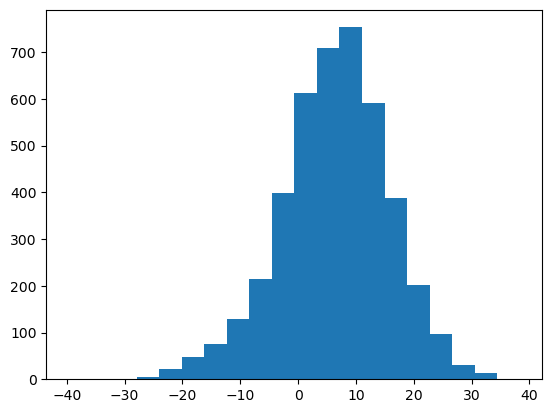

In [26]:
diffs = pr_df_2 - pr_df.set_index(cols)
plt.hist(diffs, bins=20)
plt.show()

And this looks good, we are seeing that the largest differences are ~30 mm, which is close to ~5% of the average monthly total precipitation values. We don't expect exact matches because the underlying algorithm Rasdaman uses for grid cell selection in the WCPS clip operation will not match that of masking with Rasterio.

Do the same thing for temperature:

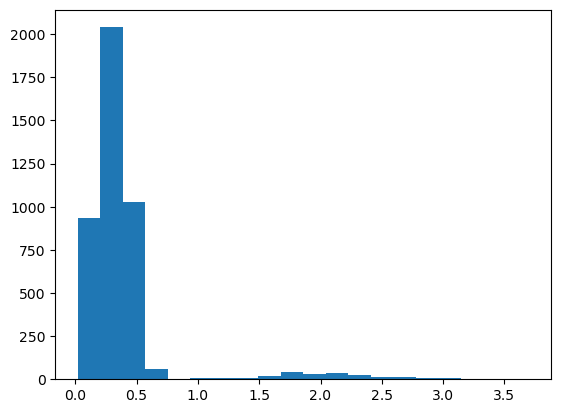

In [27]:
tas_wcps_query = wcps_query.format(
    cov_id="cmip6_monthly_air_temperature", wkt_latlon_str=wkt_latlon_str
)
tas_wcps_query = urllib.parse.quote_plus(tas_wcps_query).replace("+", "%20")

url = base_wcps_url.format(wcps_query=tas_wcps_query)
r = requests.get(url)
tas_ds_2 = xr.open_dataset(io.BytesIO(r.content))

# rename stuff too
tas_ds_2 = tas_ds_2.assign_coords(t=wcps_ts).rename(t="time", band1="tas")
tas_ds_2 = tas_ds_2.assign_coords(
    model=[model_lu[np.floor(m)] for m in tas_ds_2.model.values],
    scenario=[scenario_lu[np.floor(s)] for s in tas_ds_2.scenario.values],
    # also convert the time to a noleap calendar as it will make time-based subsetting easier
).convert_calendar("noleap", align_on="year")

tas_df_2 = (
    tas_ds_2.groupby("time.year")
    # taking mean of months for temp
    .apply(
        lambda x: x.sel(time=x.time.dt.month.isin([5, 6, 7, 8, 9])).mean(dim="time")
    ).to_dataframe()
).dropna()
diffs = tas_df_2 - tas_df.set_index(cols)
plt.hist(diffs, bins=20)
plt.show()

This looks encouraging again! Most differences are ~5% of the average temperature value (~11°C), with the largest handful of differences around ~20% of the mean. 

Let's do one more quick spot check against the raw data that was ingested into rasdaman. 

Open a single monthly file, and mask off everything but the pixels within the polygon of interest for a single time slice. Verify that this looks correct:

Text(0.5, 1.0, 'Masked DataArray with Polygon')

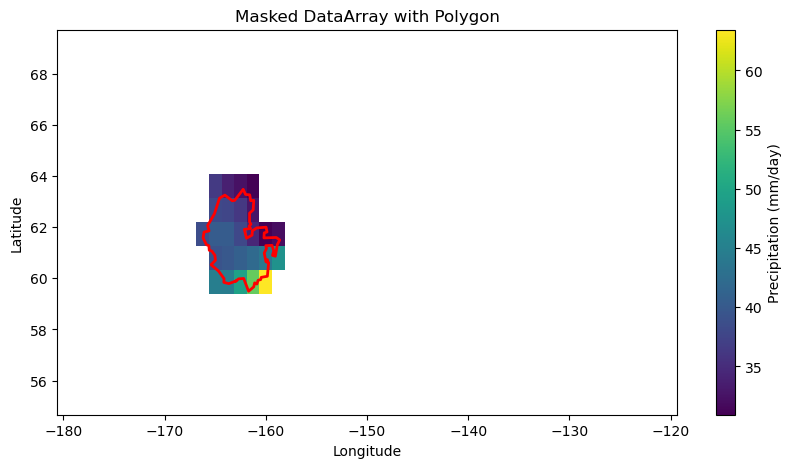

In [28]:
raw_pr_ds = xr.open_dataset("pr_Amon_CESM2_historical.nc")
# CRS-ify the dataset
raw_pr_ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
raw_pr_ds = raw_pr_ds.rio.write_crs(4326).transpose("time", "lat", "lon")
# get the new mask
raw_mask = rasterio.features.geometry_mask(
    [yk_poly_4326],
    out_shape=raw_pr_ds.pr.shape[1:],
    transform=raw_pr_ds.rio.transform(),
    invert=True,
    all_touched=True,
)

fig, ax = plt.subplots(figsize=(10, 5))
raw_pr_ds.pr.sel(time="1980-01-15").squeeze().where(raw_mask).sel(
    lon=slice(-180, -120), lat=slice(70, 55)
).plot(
    x="lon",
    ax=ax,
    label="Masked DataArray",
    cbar_kwargs={"label": "Precipitation (mm/day)"},
)

x, y = yk_poly_4326.exterior.xy
ax.plot(x, y, color="red", linewidth=2, label="Polygon")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Masked DataArray with Polygon")

Yep, looks like the same selection of pixels as seen in the plot above with data generated from the WCS query.

Now, we want to mask the time slices of interest and summarize. Let's do 1980-05 through 1980-09 (May - September). We will average within the non-masked data, and sum over the months to get our "truth" value for 1980 precipitaiton, for CESM2, and assert equivalence with the data frame: 

In [29]:
pr_accum = []
for i in range(5):
    pr_accum.append(
        np.nanmean(
            raw_pr_ds.pr.transpose("time", "lat", "lon")
            .sel(time=f"1980-0{5 + i}-15")
            .squeeze()
            .where(raw_mask)
            .values
        )
    )
assert (
    np.sum(pr_accum)
    == pr_df.query("year == 1980 & scenario == 'historical' & model == 'CESM2'")[
        "pr"
    ].values
)

Let's make a reusable function to do this kind of check a few more times:

In [30]:
def checkit(var_id, model, scenario, year, mask, df):
    raw_ds = xr.open_dataset(f"{var_id}_Amon_{model}_{scenario}.nc")
    raw_ds = raw_ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
    raw_ds = raw_ds.rio.write_crs(4326).transpose("time", "lat", "lon")

    season_accum = []
    for i in range(5):
        season_accum.append(
            np.nanmean(
                raw_ds[var_id]
                .transpose("time", "lat", "lon")
                .sel(time=f"{year}-0{5 + i}-15")
                .squeeze()
                .where(raw_mask)
                .values
            )
        )
    if var_id == "pr":
        agg = np.sum(season_accum)
        # avg for temp, sum for precip
    else:
        agg = np.mean(season_accum)
    assert (
        agg
        == df.query(f"year == {year} & scenario == '{scenario}' & model == '{model}'")[
            var_id
        ].values
    )

In [31]:
# original to verify
checkit("pr", "CESM2", "historical", 1980, raw_mask, pr_df)
# new checks
checkit("pr", "CESM2", "historical", 1990, raw_mask, pr_df)
checkit("pr", "TaiESM1", "ssp245", 2020, raw_mask, pr_df)
checkit("pr", "TaiESM1", "ssp245", 2030, raw_mask, pr_df)
checkit("tas", "GFDL-ESM4", "historical", 1985, raw_mask, tas_df)
checkit("tas", "GFDL-ESM4", "historical", 1995, raw_mask, tas_df)
checkit("tas", "MIROC6", "ssp245", 2025, raw_mask, tas_df)
checkit("tas", "MIROC6", "ssp245", 2035, raw_mask, tas_df)

Now just plot some time series to make sure things look sane:

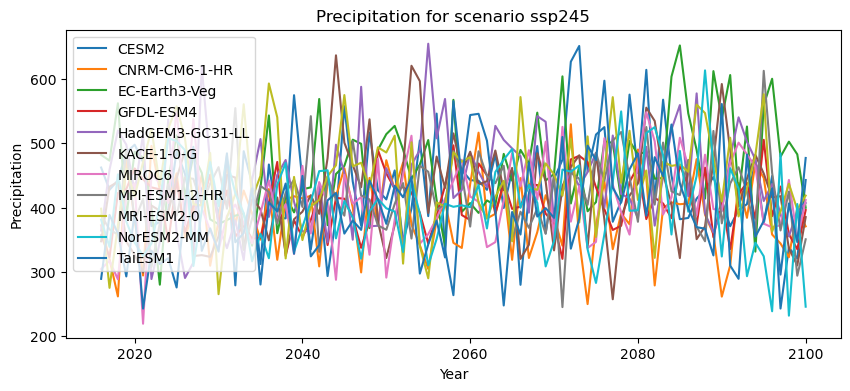

In [32]:
df_ssp245 = pr_df.query("scenario == 'ssp245' & year > 2015")
plt.figure(figsize=(10, 4))
for model in df_ssp245["model"].unique():
    model_data = df_ssp245[df_ssp245["model"] == model]
    plt.plot(model_data["year"], model_data["pr"], label=model)

plt.xlabel("Year")
plt.ylabel("Precipitation")
plt.title("Precipitation for scenario ssp245")
plt.legend()
plt.show()

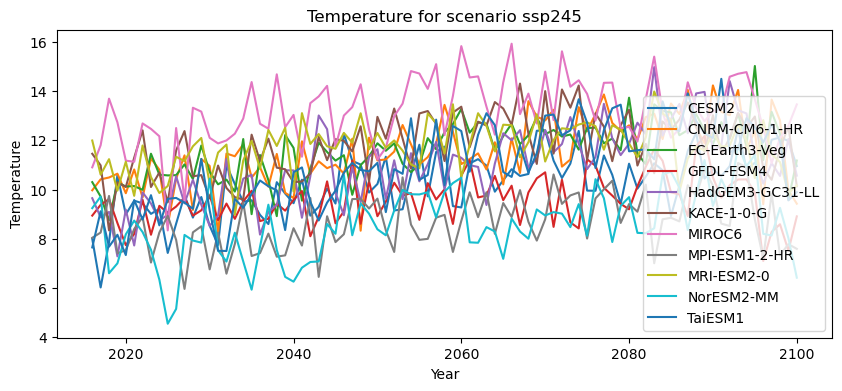

In [33]:
df_ssp245 = tas_df.query("scenario == 'ssp245' & year > 2015")
plt.figure(figsize=(10, 4))
for model in df_ssp245["model"].unique():
    model_data = df_ssp245[df_ssp245["model"] == model]
    plt.plot(model_data["year"], model_data["tas"], label=model)

plt.xlabel("Year")
plt.ylabel("Temperature")
plt.title("Temperature for scenario ssp245")
plt.legend()
plt.show()

Now some simple histograms on the full dataframes:

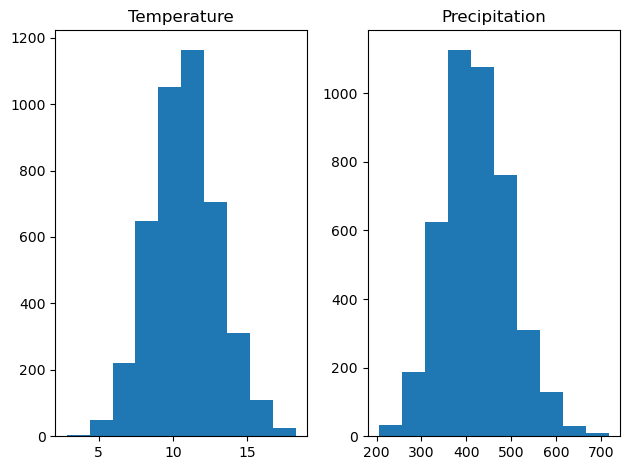

In [34]:
plt.subplot(1, 2, 1)
plt.hist(tas_df["tas"], bins=10)
plt.title("Temperature")

plt.subplot(1, 2, 2)
plt.hist(pr_df["pr"], bins=10)
plt.title("Precipitation")

plt.tight_layout()
plt.show()

All looking pretty good.

### Save data

Now just write to a file for both of temperature and precipitation:

In [35]:
tas_df.round(1).to_csv("cmip6_monthly_tas_YK.csv", index=False)
pr_df.round(1).reset_index(drop=True).to_csv("cmip6_monthly_pr_YK.csv", index=False)